In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from typing import Optional, Sequence, Tuple, List
import gstools as gs
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

### General Tools

In [2]:
def make_grid(n_points: int,
              x_min: float, x_max: float,
              y_min: float, y_max: float) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Generate a regular grid within [x_min, x_max] × [y_min, y_max].

    Parameters
    ----------
    n_points : int
        Number of points.
    x_min, x_max, y_min, y_max : float
        Bounds of the grid.

    Returns
    -------
    x_flat, y_flat, u, v : np.ndarray
    
    """
    n_x = int(np.floor(np.sqrt(n_points)))
    n_y = int(np.ceil(n_points / n_x))
    x_vals = np.linspace(x_min, x_max, n_x)
    y_vals = np.linspace(y_min, y_max, n_y)
    xx, yy = np.meshgrid(x_vals, y_vals)
    u = np.tile(np.arange(n_x), n_y)[:n_points].astype(int)
    v = np.repeat(np.arange(n_y), n_x)[:n_points].astype(int)
    return xx.ravel()[:n_points], yy.ravel()[:n_points], u, v

In [3]:
def assemble_gdf(x_spatial: np.ndarray,
                 y_spatial: np.ndarray,
                 u: np.ndarray, v: np.ndarray,
                 a1_array: np.ndarray, a2_array: np.ndarray, b_array: np.ndarray,
                 X1: np.ndarray, X2: np.ndarray,
                 y: np.ndarray,
                 crs: str = "EPSG:4326") -> Tuple[pd.DataFrame, gpd.GeoDataFrame]:
    """
    Assemble results into DataFrame and GeoDataFrame with geometry.

    Parameters
    ----------
    x_spatial, y_spatial : np.ndarray
        Spatial coordinates.
    u, v : np.ndarray
        Grid indices.
    a1_array, a2_array, b_array : np.ndarray
        Coefficient fields.
    X1, X2 : np.ndarray
        Features.
    y : np.ndarray
        Response values.
    crs : str
        Coordinate reference system.

    Returns
    -------
    df, gdf : (pd.DataFrame, gpd.GeoDataFrame)
    """
    df = pd.DataFrame({
        'u': u,
        'v': v,
        'spatial_x': x_spatial,
        'spatial_y': y_spatial,
        'a1_list': a1_array,
        'a2_list': a2_array,
        'b_list':  b_array,
        'feat1': X1,
        'feat2': X2,
        'y': y
    })
    geometry = [Point(x, y) for x, y in zip(df['spatial_x'], df['spatial_y'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs=crs)
    return df, gdf

In [4]:
def plt_sub(df, fields: List[str], add_colorbar: bool = True, ncols: int = 2, figsize: Tuple[int, int] = (12, 6)):
    """
    Visualize multiple fields on a grid using subplots.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain 'u', 'v' and the target fields.
    fields : list of str
        Names of fields to visualize.
    add_colorbar : bool
        Whether to add a colorbar for each subplot.
    ncols : int
        Number of subplots per row.
    figsize : tuple
        Size of the entire figure.
    """
    size_x = len(np.unique(df['v']))
    size_y = len(np.unique(df['u']))
    n_fields = len(fields)
    nrows = int(np.ceil(n_fields / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
    for i, field in enumerate(fields):
        region_array = df.sort_values(['v', 'u'])[field].to_numpy()
        region_grid = region_array.reshape(size_x, size_y)
        ax = axes[i // ncols, i % ncols]
        im = ax.imshow(region_grid, origin='lower')
        ax.set_title(f"{field}")
        ax.set_xlabel("X Index")
        ax.set_ylabel("Y Index")
        if add_colorbar:
            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    for j in range(i + 1, nrows * ncols):
        fig.delaxes(axes[j // ncols, j % ncols])
    plt.tight_layout()
    plt.show()

### Feature Generators

In [5]:
def gen_uniform(n_points: int = 2500,
                low: float = -1.0, high: float = 1.0,
                random_seed: int = 42) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate two independent uniform features X1, X2.

    Parameters
    ----------
    n_points : int
        Number of samples.
    low, high : float
        Range of the uniform distribution.
    random_seed : int
        Random seed.

    Returns
    -------
    x1, x2 : np.ndarray
    """
    rng = np.random.default_rng(random_seed)
    x1 = rng.uniform(low, high, n_points)
    x2 = rng.uniform(low, high, n_points)
    return x1, x2

In [6]:
def gen_corr_grf(n_points: int = 2500,
                 x_min: float = 0.0, x_max: float = 10.0,
                 y_min: float = 0.0, y_max: float = 10.0,
                 rho: float = 0.3,
                 model: str = "Gaussian",
                 var: float = 1.0,
                 len_scale: float = 0.2,
                 random_seed: int = 42) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate two correlated GRF features X1, X2 with target correlation ~rho.

    Parameters
    ----------
    n_points : int
        Number of samples.
    x_min, x_max, y_min, y_max : float
        Grid bounds.
    rho : float
        Target correlation.
    model : str
        Covariance model ('Gaussian', 'Exponential', 'Matern').
    var : float
        Variance.
    len_scale : float
        Correlation length scale.
    random_seed : int
        Random seed.

    Returns
    -------
    x1, x2 : np.ndarray
    """
    x_flat, y_flat, _, _ = make_grid(n_points, x_min, x_max, y_min, y_max)
    xs = np.unique(x_flat)
    ys = np.unique(y_flat)
    if model == "Gaussian":
        cov_model = gs.Gaussian(dim=2, var=var, len_scale=len_scale)
    elif model == "Exponential":
        cov_model = gs.Exponential(dim=2, var=var, len_scale=len_scale)
    elif model == "Matern":
        cov_model = gs.Matern(dim=2, var=var, len_scale=len_scale, nu=1.5)
    else:
        raise ValueError(f"Unsupported covariance model: {model!r}")
    srf1 = gs.SRF(cov_model, seed=random_seed)
    srf2 = gs.SRF(cov_model, seed=random_seed + 1)
    G1 = srf1.structured([xs, ys]).ravel()
    G2 = srf2.structured([xs, ys]).ravel()
    x1 = G1
    x2 = rho * G1 + np.sqrt(1.0 - rho**2) * G2
    return x1, x2

### Data Bulider

In [7]:
def comp_y(X1: np.ndarray,
           X2: np.ndarray,
           a1_array: np.ndarray,
           a2_array: np.ndarray,
           b_array: np.ndarray,
           sigma_each: np.ndarray,
           rng: Optional[np.random.Generator] = None) -> np.ndarray:
    """
    Compute response y using point-wise coefficients and noise: y = a1*X1 + a2*X2 + b + eps.

    Parameters
    ----------
    X1, X2 : np.ndarray
        Features.
    a1_array, a2_array, b_array : np.ndarray
        Coefficients.
    sigma_each : np.ndarray
        Point-wise noise standard deviation.
    rng : np.random.Generator
        Optional random generator.

    Returns
    -------
    y : np.ndarray
    """
    X1 = np.asarray(X1).reshape(-1)
    X2 = np.asarray(X2).reshape(-1)
    a1_array = np.asarray(a1_array).reshape(-1)
    a2_array = np.asarray(a2_array).reshape(-1)
    b_array  = np.asarray(b_array).reshape(-1)
    sigma_each = np.asarray(sigma_each).reshape(-1)
    n = X1.size
    if not (X2.size == a1_array.size == a2_array.size == b_array.size == sigma_each.size == n):
        raise ValueError("Array lengths must match.")
    if rng is None:
        rng = np.random.default_rng()
    eps = rng.normal(0.0, sigma_each, size=n)
    return a1_array * X1 + a2_array * X2 + b_array + eps

In [8]:
def gen_voronoi_data(n_points: int = 500,
                     x_min: float = 0, x_max: float = 10,
                     y_min: float = 0, y_max: float = 10,
                     random_seed: int = 42,
                     *,
                     X1: np.ndarray,
                     X2: np.ndarray,
                     region_labels: Optional[np.ndarray] = None,
                     coefs: Optional[Sequence[Tuple[float, float, float]]] = None,
                     noise_scales: Optional[Sequence[float]] = None,
                     crs: str = "EPSG:4326") -> Tuple[pd.DataFrame, gpd.GeoDataFrame]:
    """
    Generate Voronoi-based data with coefficients and noise expanded point-wise.

    Parameters
    ----------
    n_points : int
        Number of samples.
    x_min, x_max, y_min, y_max : float
        Grid bounds.
    random_seed : int
        Random seed.
    X1, X2 : np.ndarray
        Features.
    region_labels : np.ndarray
        Optional region labels (1..K).
    coefs : list of (a1,a2,b)
        Coefficients per region.
    noise_scales : list of float
        Noise scales per region.
    crs : str
        Coordinate reference system.

    Returns
    -------
    df, gdf : DataFrame and GeoDataFrame
    """
    rng = np.random.default_rng(random_seed)
    x_spatial, y_spatial, u, v = make_grid(n_points, x_min, x_max, y_min, y_max)
    X1 = np.asarray(X1).reshape(-1)
    X2 = np.asarray(X2).reshape(-1)
    if X1.size != n_points or X2.size != n_points:
        raise ValueError("X1 and X2 must match n_points.")
    if coefs is not None:
        K = len(coefs)
    elif region_labels is not None:
        K = int(np.max(region_labels))
    else:
        K = 5
    if region_labels is None:
        seeds = np.c_[rng.uniform(x_min, x_max, K),
                      rng.uniform(y_min, y_max, K)]
        pts = np.c_[x_spatial, y_spatial]
        idx = cKDTree(seeds).query(pts, k=1)[1]
        region_labels = idx.astype(int) + 1
    region_labels = np.asarray(region_labels).astype(int)
    if region_labels.size != n_points:
        raise ValueError("region_labels length mismatch.")
    if coefs is None:
            a1k = rng.uniform(-3.0, 4.0, size=K)
            a2k = rng.uniform(-3.0, 4.0, size=K)
            bk  = rng.uniform(0.0, 10.0, size=K)
            coefs = list(zip(a1k, a2k, bk))
    if noise_scales is None:
        noise_scales = [1] * K
    a1_array = np.empty(n_points)
    a2_array = np.empty(n_points)
    b_array = np.empty(n_points)
    sigma_each = np.empty(n_points)
    for r in range(1, K + 1):
        idx = (region_labels == r)
        a1, a2, b0 = coefs[r - 1]
        a1_array[idx], a2_array[idx], b_array[idx] = a1, a2, b0
        sigma_each[idx] = noise_scales[r - 1]
    y = comp_y(X1, X2, a1_array, a2_array, b_array, sigma_each, rng)
    return assemble_gdf(x_spatial, y_spatial, u, v, a1_array, a2_array, b_array, X1, X2, y, crs=crs)

In [9]:
def dis_surface(values: np.ndarray,
                pivot: float = 0.0,
                upper_cap: Optional[int] = None,
                lower_cap: Optional[int] = None) -> np.ndarray:
    """
    Discretize a continuous surface by rounding below/above a pivot and applying optional caps.

    Parameters
    ----------
    values : np.ndarray
        Continuous values.
    pivot : float
        Threshold for floor/ceil rounding.
    upper_cap, lower_cap : int or None
        Upper/lower caps.

    Returns
    -------
    disc : np.ndarray
        Discretized array.
    """
    v = np.asarray(values, dtype=float)
    disc = np.where(v < pivot, np.floor(v), np.ceil(v))
    if upper_cap is not None:
        disc = np.minimum(disc, upper_cap)
    if lower_cap is not None:
        disc = np.maximum(disc, lower_cap)
    return disc

## Main

### X: GRF with correlation

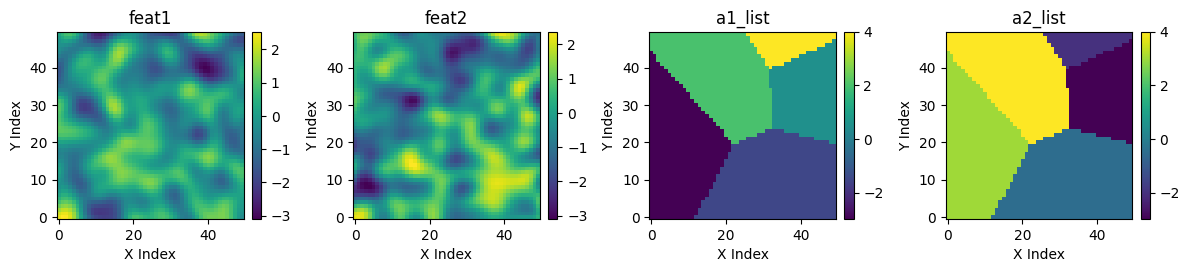

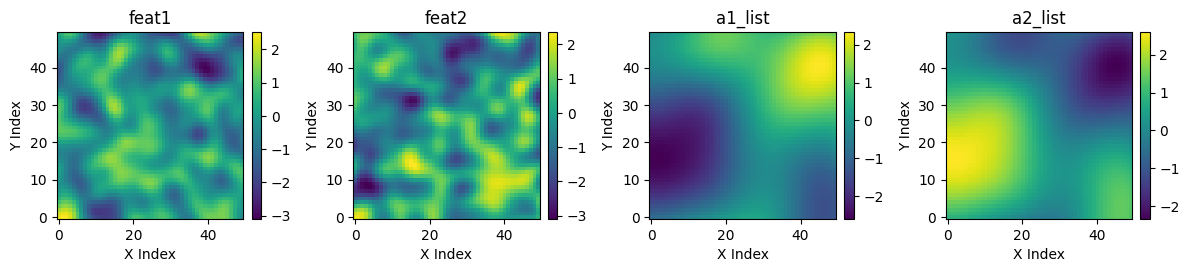

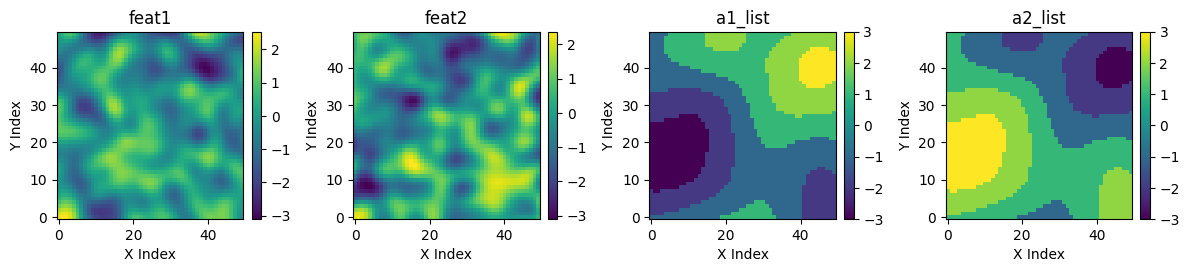

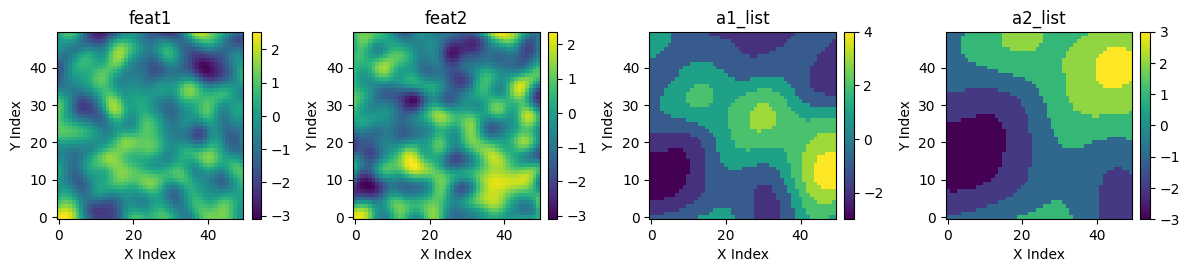

In [10]:
if __name__ == "__main__":
    n_pts = 2500
    x_min, x_max, y_min, y_max = 0.0, 10.0, 0.0, 10.0
    x_spatial, y_spatial, u, v = make_grid(n_pts, x_min, x_max, y_min, y_max)

    
# Generation X
    X1_g, X2_g = gen_corr_grf(
        n_points=n_pts, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max,
        rho=0.3, model="Gaussian", var=1.0, len_scale=0.8, random_seed=42
    )

    
# Voronoi coefs set
    coefs_demo = [
        (4.0,  -2.0,  3.0),
        (2.0,   4.0,  3.0),
        (0.5,  -3.0,  3.0),
        (-1.5, -0.5,  3.0),
        (-3.0,  3.0,  3.0),
    ]
    noise_scales_demo = [1, 1, 1, 1, 1]

    df_vor_grf_g, gdf_vor_grf_g = gen_voronoi_data(
        n_points=n_pts,
        x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max,
        random_seed=42,
        X1=X1_g, X2=X2_g,
        coefs=coefs_demo,
        noise_scales=noise_scales_demo,
        crs="EPSG:3857"
    )
    # Vis
    plt_sub(df_vor_grf_g, fields=['feat1', 'feat2', 'a1_list', 'a2_list'], add_colorbar=True, ncols=4)

    
# Continuous coefficient field
    a1, _ = gen_corr_grf(
        n_points=n_pts, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max,
        rho=0.0, var=1, len_scale=3, random_seed=321
    )
    a2 = -a1
    sigma_each = np.ones(n_pts, dtype=int)
    b = 3 * np.ones(n_pts, dtype=int)
    rng = np.random.default_rng(42)
    y = comp_y(X1_g, X2_g, a1, a2, b, sigma_each, rng)

    df_grf_g, gdf_grf_g = assemble_gdf(
        x_spatial, y_spatial, u, v,
        a1_array=a1, a2_array=a2, b_array=b,
        X1=X1_g, X2=X2_g, y=y,
        crs="EPSG:3857"
    )
    # Vis
    plt_sub(df_grf_g, fields=['feat1', 'feat2', 'a1_list', 'a2_list'], add_colorbar=True, ncols=4)

    
# Discretized coefficients
    a1_d = dis_surface(a1, upper_cap=4, lower_cap=-4)
    a2_d = -a1_d
    df_grf_dis_g, gdf_grf_dis_g = assemble_gdf(
        x_spatial, y_spatial, u, v,
        a1_array=a1_d, a2_array=a2_d, b_array=b,
        X1=X1_g, X2=X2_g, y=y,
        crs="EPSG:3857"
    )
    # Vis
    plt_sub(df_grf_dis_g, fields=['feat1', 'feat2', 'a1_list', 'a2_list'], add_colorbar=True, ncols=4)

    
# Multi-scale discretized surfaces
    a1_md, _ = gen_corr_grf(
        n_points=n_pts, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max,
        rho=0.0, var=1, len_scale=2, random_seed=321
    )
    a2_md, _ = gen_corr_grf(
        n_points=n_pts, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max,
        rho=0.0, var=1, len_scale=3, random_seed=321
    )
    a1_md = dis_surface(a1_md, upper_cap=4, lower_cap=-4)
    a2_md = dis_surface(a2_md, upper_cap=4, lower_cap=-4)

    df_grf_m_dis_g, gdf_grf_m_dis_g = assemble_gdf(
        x_spatial, y_spatial, u, v,
        a1_array=a1_md, a2_array=a2_md, b_array=b,
        X1=X1_g, X2=X2_g, y=y,
        crs="EPSG:3857"
    )
    # Vis
    plt_sub(df_grf_m_dis_g, fields=['feat1', 'feat2', 'a1_list', 'a2_list'], add_colorbar=True, ncols=4)

### X: Uniform without correlation

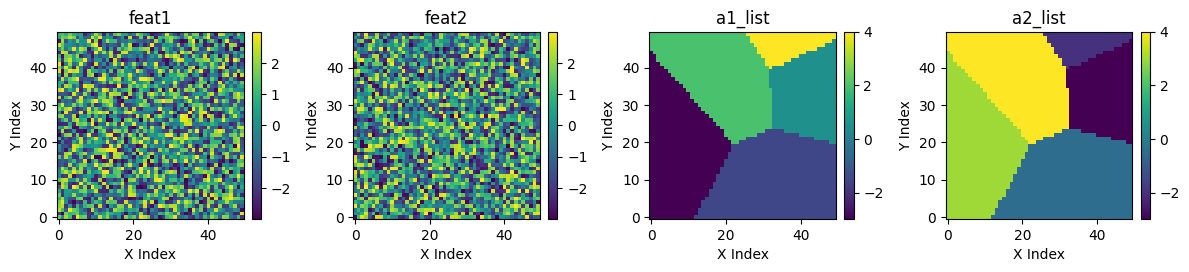

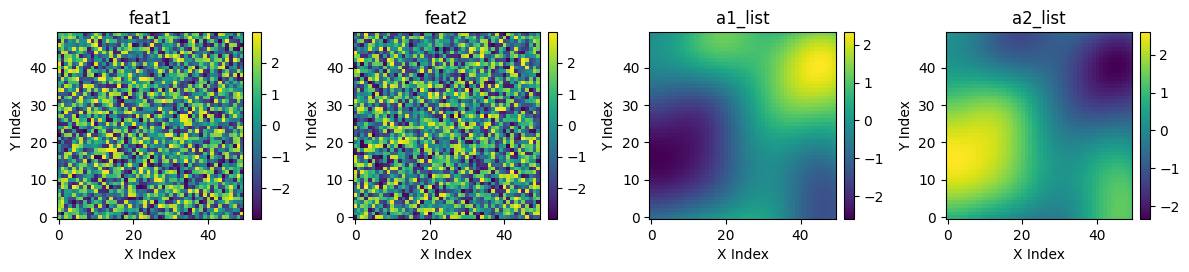

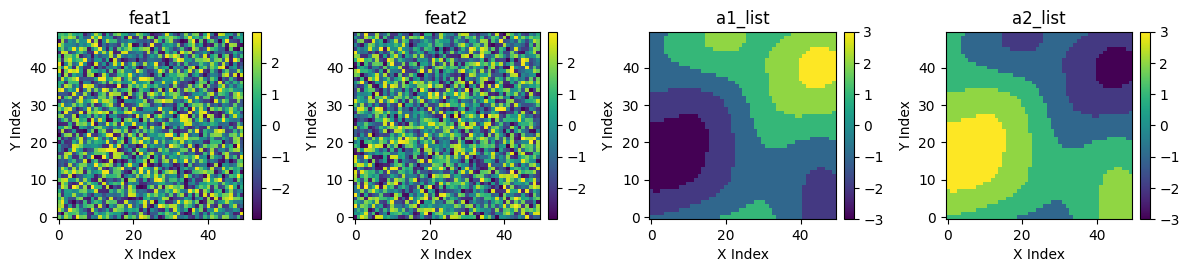

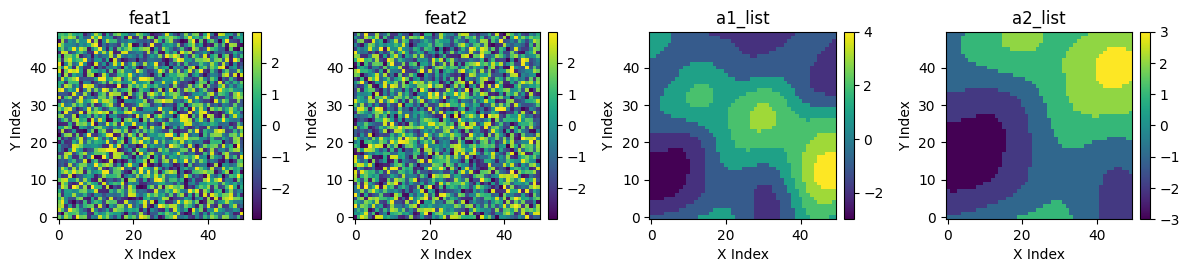

In [14]:
# Generation X
    X1_u, X2_u = gen_uniform(n_points=n_pts, low=-3, high=3, random_seed=42)


# Voronoi coefs set
    coefs_demo = [
        (4.0,  -2.0,  3.0),
        (2.0,   4.0,  3.0),
        (0.5,  -3.0,  3.0),
        (-1.5, -0.5,  3.0),
        (-3.0,  3.0,  3.0),
    ]
    noise_scales_demo = [1, 1, 1, 1, 1]

    df_vor_u, gdf_vor_u = gen_voronoi_data(
        n_points=n_pts,
        x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max,
        random_seed=42,
        X1=X1_u, X2=X2_u,
        coefs=coefs_demo,
        noise_scales=noise_scales_demo,
        crs="EPSG:3857"
    )
    # Vis
    plt_sub(df_vor_u, fields=['feat1', 'feat2', 'a1_list', 'a2_list'], add_colorbar=True, ncols=4)


# Continuous coefficient field
    a1, _ = gen_corr_grf(
        n_points=n_pts, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max,
        rho=0.0, var=1, len_scale=3, random_seed=321
    )
    a2 = -a1
    sigma_each = np.ones(n_pts, dtype=int)
    b = 3 * np.ones(n_pts, dtype=int)
    rng = np.random.default_rng(42)
    y = comp_y(X1_u, X2_u, a1, a2, b, sigma_each, rng)

    df_coef_u, gdf_coef_u = assemble_gdf(
        x_spatial, y_spatial, u, v,
        a1_array=a1, a2_array=a2, b_array=b,
        X1=X1_u, X2=X2_u, y=y,
        crs="EPSG:3857"
    )
    # Vis
    plt_sub(df_coef_u, fields=['feat1', 'feat2', 'a1_list', 'a2_list'], add_colorbar=True, ncols=4)


# Discretized coefficients
    a1_d = dis_surface(a1, upper_cap=4, lower_cap=-4)
    a2_d = -a1_d
    df_dis_u, gdf_dis_u = assemble_gdf(
        x_spatial, y_spatial, u, v,
        a1_array=a1_d, a2_array=a2_d, b_array=b,
        X1=X1_u, X2=X2_u, y=y,
        crs="EPSG:3857"
    )
    # Vis
    plt_sub(df_dis_u, fields=['feat1', 'feat2', 'a1_list', 'a2_list'], add_colorbar=True, ncols=4)


# Multi-scale discretized surfaces
    a1_md, _ = gen_corr_grf(
        n_points=n_pts, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max,
        rho=0.0, var=1, len_scale=2, random_seed=321
    )
    a2_md, _ = gen_corr_grf(
        n_points=n_pts, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max,
        rho=0.0, var=1, len_scale=3, random_seed=321
    )
    a1_md = dis_surface(a1_md, upper_cap=4, lower_cap=-4)
    a2_md = dis_surface(a2_md, upper_cap=4, lower_cap=-4)

    df_mdis_u, gdf_mdis_u = assemble_gdf(
        x_spatial, y_spatial, u, v,
        a1_array=a1_md, a2_array=a2_md, b_array=b,
        X1=X1_u, X2=X2_u, y=y,
        crs="EPSG:3857"
    )
    # Vis
    plt_sub(df_mdis_u, fields=['feat1', 'feat2', 'a1_list', 'a2_list'], add_colorbar=True, ncols=4)